<a href="https://colab.research.google.com/github/AnetaKovacheva/credit-card-fraud-detection/blob/main/Credit_cards_fraud_detection_with_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fraud detection in credit cards transactions with `PyCaret`

This Notebook explores the binary classification package offered by [`PyCaret`](https://pycaret.org/). The latter is an open-source, low-code machine learning library in Python that automates machine learning workflows.

To try-and-test this package, and to demostrate how it works, I use the [`Credit card fraud data`](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data) available on Kaggle. The dataset was complied to allow studing the fraud phenomenon in cashless payments. It was specifically noted that digital payments are evolving, so are cyber criminals. According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows that fraud is still very common both for Card-Present and Card-not Present type of payments. Therefore, in today’s digital world where trillions of card transaction happen per day, detection of fraud is challenging.

The Notebook is organised in several chapters.
  1. Load data
  2. Exploratory Data Analysis
  3. Data preprocessing (prepare data for modelling)
  4. Setup classification experiment
  5. Predict if a transation is a fraud, or not

Because `PyCaret` is neither part of Anaconda, nor pre-installed in Colab or Kaggle, we need to pip-install it manually.

In [1]:
# !pip install pycaret

#### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
plt.style.use(style='Solarize_Light2')

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

from pycaret.classification import *
from pycaret.classification import ClassificationExperiment

## 1. Load data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/small_tasks/card_transdata.csv')
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Dataset's features hold information as follows:

    distance_from_home - the distance from home where the transaction happened

    distance_from_last_transaction - the distance from last transaction happened

    ratio_to_median_purchase_price - Ratio of purchased price transaction to median purchase price

    repeat_retailer - Is the transaction happened from same retailer

    used_chip - Is the transaction through chip (credit card)

    used_pin_number - Is the transaction happened by using PIN number

    online_order - Is the transaction an online order

    fraud - Is the transaction fraudulent

## 2. Exploratory Data Analysis

#### 2.1. Dataset shape

In [4]:
print(f'The original dataset has {data.shape[1]} columns.')
print(f'The original dataset has {data.shape[0]} samples (rows).')

The original dataset has 8 columns.
The original dataset has 1000000 samples (rows).


#### 2.2. Check dtype and missing values

In [5]:
print('All column values are floating point numbers and there are not missing values')
data.info()

All column values are floating point numbers and there are not missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


 #### 2.3 Check for duplicates

In [6]:
print(f'Number of duplicate samples: {data.duplicated().sum()}')

Number of duplicate samples: 0


#### 2.4. Check for outliers

In [7]:
print('Display min and max values in each column')
print('==========================================')
for col in data.columns:
    print(f'Min value in {col}: {data[col].min()} <==> Max value: {data[col].max()}')

Display min and max values in each column
Min value in distance_from_home: 0.0048743850667442 <==> Max value: 10632.723672241103
Min value in distance_from_last_transaction: 0.000118281615244 <==> Max value: 11851.10456494614
Min value in ratio_to_median_purchase_price: 0.004399239615964 <==> Max value: 267.8029421832708
Min value in repeat_retailer: 0.0 <==> Max value: 1.0
Min value in used_chip: 0.0 <==> Max value: 1.0
Min value in used_pin_number: 0.0 <==> Max value: 1.0
Min value in online_order: 0.0 <==> Max value: 1.0
Min value in fraud: 0.0 <==> Max value: 1.0


In [8]:
print('Show 5 num statistics plus counts, mean value and standard deviation per column')
data.describe().T

Show 5 num statistics plus counts, mean value and standard deviation per column


,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


The 5 number statistics and the distance between the minimum and maxium values in three colums - *distance from home*, *distance from the last transaction*, and the *ratio of median price to purchase price*, suggest that there are outliers in these variables. These are visualised in the plot below. Thereafter, the outliers are removed from the dataset.

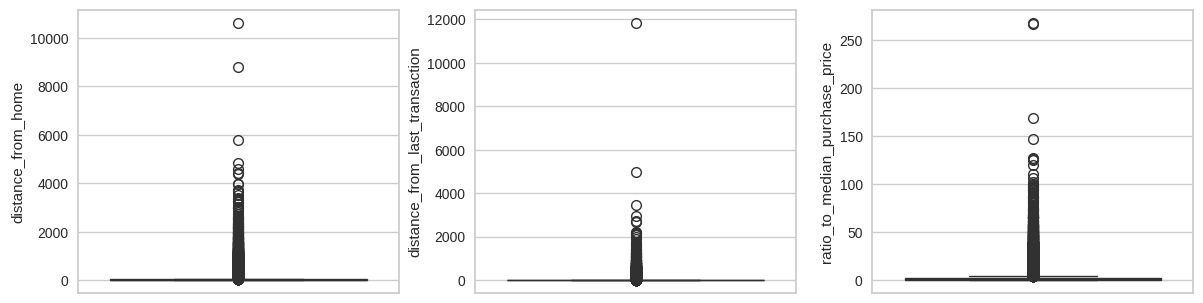

In [9]:
# Display outliers in columns with continues values
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 3))
idx = 0

axs = axs.flatten()
for k, v in data[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']].items():
    sns.boxplot(y = k, data = data[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']], ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.5, w_pad = 0.5, h_pad = 5.0)

##### Option 1. Remove outliers

In [10]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [11]:
data_no_outliers = data.copy()
for col in data[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']]:
    data_no_outliers = remove_outliers(data_no_outliers, col)

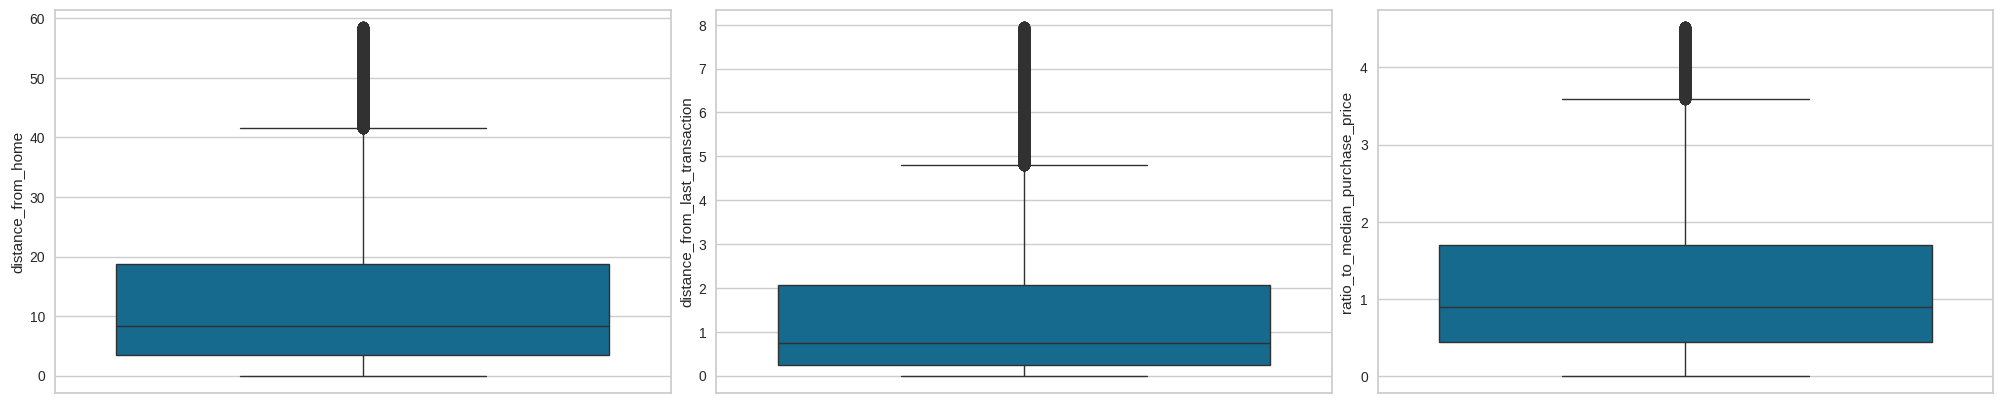

In [12]:
# Display continues values in numerical features on boxplots after removing outliers
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 4))
idx = 0

axs = axs.flatten()
for k, v in data_no_outliers[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']].items():
    sns.boxplot(y = k, data = data_no_outliers[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']], ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.5, w_pad = 0.5, h_pad = 5.0)

In [13]:
print(f'Without outliers, the dataset has {data_no_outliers.shape[1]} columns.')
print(f'Without outliers, the dataset has {data_no_outliers.shape[0]} samples (rows).')

Without outliers, the dataset has 8 columns.
Without outliers, the dataset has 718686 samples (rows).


#### 2.5. Check categorical (binary) features vs label

In [14]:
def cross_counts(col1, col2):
  '''
  Displays counts in a column per class
  Args: column 1 to display counts, column 2 to indicate class
  Returns count plot
  '''
  plt.figure(figsize = (7, 4))
  sns.countplot(data = data, x = col1, hue = col2)
  plt.title(f'{col1} vs. {col2}', weight = 'bold')
  plt.xlabel(f'{col1}', size = 10, weight = 'bold')
  plt.ylabel('Count', size = 10, weight = 'bold')
  plt.show()

The plot below suggests that fraudulent transactions are more common for online trade.

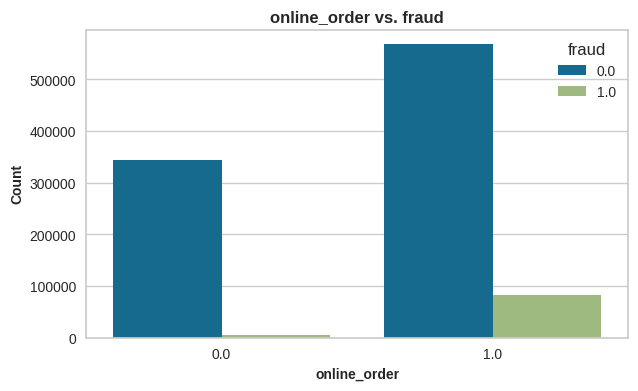

In [15]:
cross_counts('online_order', 'fraud')

Frauds are less common in transactions where PIN number should be entered for validating the purchase.

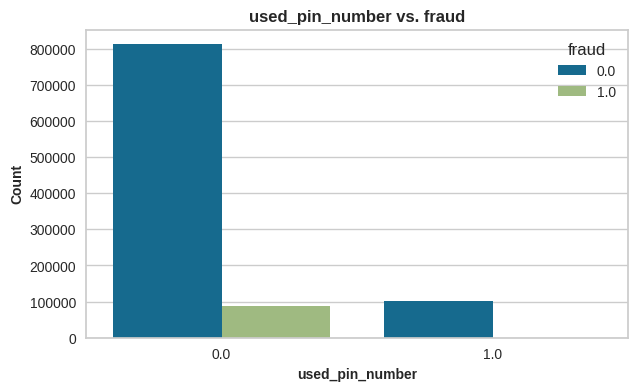

In [16]:
cross_counts('used_pin_number', 'fraud')

Similarly, credit cards protected with chip, are less likely to be used for fraudulent transactions.

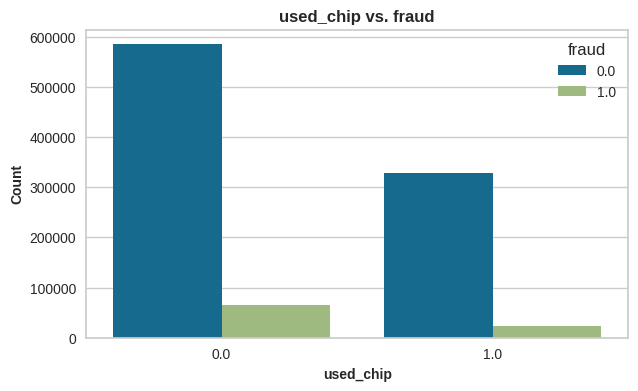

In [17]:
cross_counts('used_chip', 'fraud')

The plot below reveals that a fraudulent payment is much more likely to happen to a retailer who already had transactions with the same credit card.

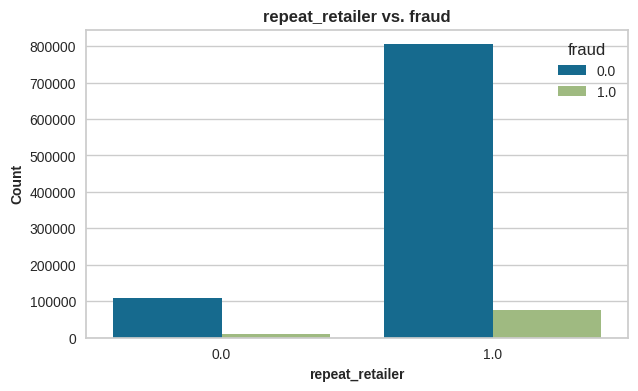

In [18]:
cross_counts('repeat_retailer', 'fraud')

The pie charts below visually display the share of positive and negative 'events' in the features with binary values.

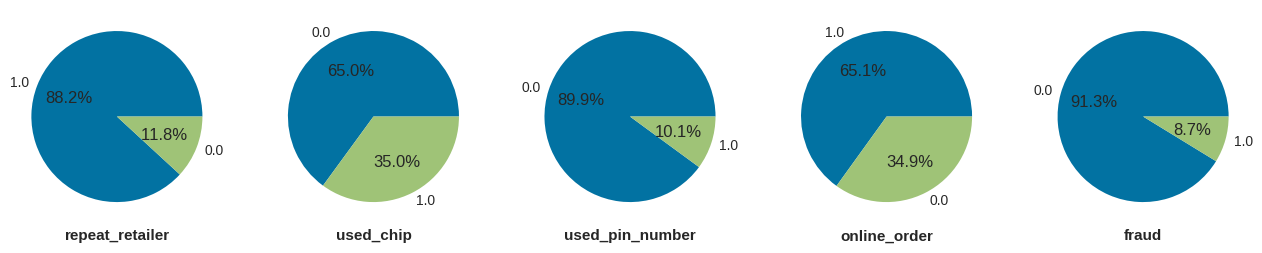

In [19]:
# Display share of unique values in categorical features and label
cat_features = ['repeat_retailer', 'used_chip',\
                'used_pin_number', 'online_order', 'fraud']

plt.figure(figsize = (16, 12))
for i, col in enumerate(cat_features):
    plt.subplot(1, 5, i+1)
    plt.pie(x = data[col].value_counts().values,
            labels = data[col].value_counts().index,
            autopct = '%1.1f%%')
    plt.xlabel(col, weight = 'bold')
plt.show()

#### 2.6. Check correlation

It does not seems that there is a strong correlation - positive or negative - between the features in the dataset. A moderate strength is observed between the availability of fraud and the ratio between median price to the purchase price (correlation of 0.45).

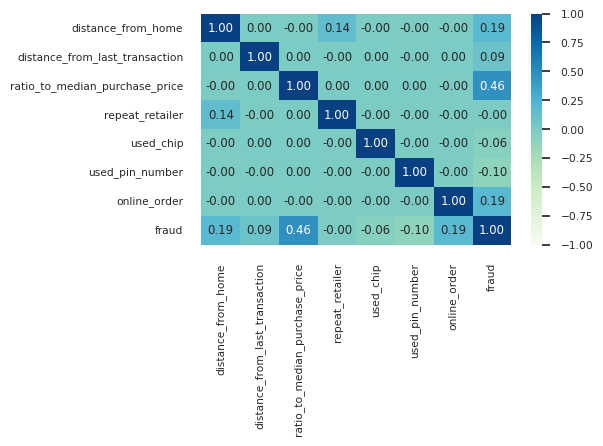

In [20]:
# Check correlation between features
plt.figure(figsize = (5,3))
sns.set(font_scale=0.7)
sns.heatmap(data.corr(), fmt=".2f", vmin=-1.0, vmax=1.0, cmap = 'GnBu', annot=True)
plt.show()

In [21]:
# Display correlation of all features with label
corr = data.corr()['fraud'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient('GnBu')

,fraud
fraud,1.000000
ratio_to_median_purchase_price,0.462305
online_order,0.191973
distance_from_home,0.187571
distance_from_last_transaction,0.091917
repeat_retailer,-0.001357
used_chip,-0.060975
used_pin_number,-0.100293


##### Option 2. Balance dataset

The Exploratory Data Analysis showed that the credit card fraud detection dataset is quite imbalanced - less than 9% of all transactions are fraudulent. This could be a problem for the modelling algorithms since imbalanced data introduce bias. The issue of imbalanced data could be addressed either by adding more samples to the undersampled class, or by removing data from the oversampled class. The easiest approach is to balance the data with `SMOTE`- Synthetic Minority Oversampling Technique.

In [22]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
data_x, data_y = smote.fit_resample(data_no_outliers.drop('fraud', axis = 1), data_no_outliers.fraud)

In [23]:
print(f'Balance before SMOTE: {data_no_outliers.fraud.value_counts()}')
print('==============================================')
print(f'Balance after SMOTE: {data_y.value_counts()}')

Balance before SMOTE: 0.0    709694
1.0      8992
Name: fraud, dtype: int64
Balance after SMOTE: 0.0    709694
1.0    709694
Name: fraud, dtype: int64


Becasue `SMOTE` returns features and labels in separate variables, we need to put them in a single one - a format expected by `PyCaret` algorithms.

In [24]:
data_x['fraud'] = data_y

### 3. Get data for modelling

In [25]:
# data_x - balanced data without outliers
# data_no_outliers - imbalanced data without outliers
# data - imbalanced data with outliers

# Get less data to speed up training
data_fin = data.sample(200000)

In [26]:
# Reset index and check shape
data_fin = data_fin.reset_index()

print(f'Without outliers, the dataset has {data_fin.shape[1]} columns.')
print(f'Without outliers, the dataset has {data_fin.shape[0]} samples (rows).')

Without outliers, the dataset has 9 columns.
Without outliers, the dataset has 200000 samples (rows).


In [27]:
# Display dataset
data_fin.head()

,index,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,761728,5.565473,2.322745,2.091207,1.0,0.0,0.0,1.0,0.0
1,766647,1.976312,0.022041,0.325249,1.0,0.0,0.0,0.0,0.0
2,909116,2.747219,0.502861,1.662257,1.0,1.0,0.0,0.0,0.0
3,921660,27.689728,5.569473,0.644405,1.0,0.0,1.0,1.0,0.0
4,277355,0.508032,17.738295,4.654703,0.0,0.0,0.0,1.0,1.0


In [28]:
# Remove 'index' column and display top 5 rows
data_fin.drop('index', axis = 1, inplace = True)
data_fin.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,5.565473,2.322745,2.091207,1.0,0.0,0.0,1.0,0.0
1,1.976312,0.022041,0.325249,1.0,0.0,0.0,0.0,0.0
2,2.747219,0.502861,1.662257,1.0,1.0,0.0,0.0,0.0
3,27.689728,5.569473,0.644405,1.0,0.0,1.0,1.0,0.0
4,0.508032,17.738295,4.654703,0.0,0.0,0.0,1.0,1.0


Further preporcessing is not performed since `PyCaret` takes care of normalisation (e.g., by applying zscore), encoding (e.g., by convering categorical values in numeric ones), and split (train-test split).

### 4. Setup classification experiment

A Classification experiment, i.e., training, testing, and evaluating various models, is launched by instantiating an experiment by calling `ClassificiationExperiment()`. It is then setup by passing the entire dataset, including labels. The function requires specifying the target varible and the session id. The other hyperparameters could also be fine-tuned by updating configuration modules.

In [30]:
exp = ClassificationExperiment()

The `setup()` output visualises parameters' values. We see the target type (binary), the dataset's shape, the size of the train and test data, number of numeric features (if there were categorical ones, they would be mentioned in this summary as well), imputation rules (in case there were missing values in the dataset, and number of folders for cross validation.

In [31]:
exp.setup(data_fin, target = 'fraud', session_id = 123)

,Description,Value
0,Session id,123
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(200000, 8)"
4,Transformed data shape,"(200000, 8)"
5,Transformed train set shape,"(140000, 8)"
6,Transformed test set shape,"(60000, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


By calling `compare_models()` over the setup experiment, all preliminary instantiated algorithms are trained, validated and evaluated. We see that the ouput offers information about the type of Machine Learning algorithm trained and the most widely used classification metrics - accuracy, AUC, recall, precision, and f1 score. Kappa is a metric that calculates the similarity between predictions and actuals. Matthews Correlation Coefficient (MCC) considers all four elements of the confusion matrix (true positives, true negatives, false positives, and false negatives) and considers the balance between them. It is suitable for imbalanced data sets or situations where the consequences of false positives and false negatives are not equal. At the end, the output shows the time in seconds needed to train each model.

The best performing model is shown at the top of the table, and the best scores (accorss all algorithms and metrics) are coloured in yellow. In our example, we see that both the Decision Tree and Random Forest reached similar performance but it took 14 seconds to train the latter, and less than one second - to educate the former.

It should be noted here that most tree-based algorithms reach the highest model performance in terms of accuracy, AUC, precision, recall and f1 score when trained on balanced data and data without outliers.

In [32]:
# Compare baseline models
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9999,0.9997,0.9995,0.9994,0.9995,0.9994,0.9994,0.3010
rf,Random Forest Classifier,0.9999,1.0000,0.9995,0.9999,0.9997,0.9997,0.9997,12.2340
ada,Ada Boost Classifier,0.9997,1.0000,0.9981,0.9980,0.9981,0.9979,0.9979,5.3350
gbc,Gradient Boosting Classifier,0.9996,0.9999,0.9956,0.9995,0.9975,0.9973,0.9973,21.5580
xgboost,Extreme Gradient Boosting,0.9990,1.0000,0.9959,0.9929,0.9944,0.9939,0.9939,0.9490
et,Extra Trees Classifier,0.9987,1.0000,0.9871,0.9976,0.9923,0.9916,0.9916,5.0460
lightgbm,Light Gradient Boosting Machine,0.9984,1.0000,0.9948,0.9873,0.9910,0.9901,0.9901,6.0170
knn,K Neighbors Classifier,0.9681,0.9850,0.8327,0.8079,0.8200,0.8025,0.8027,1.6400
lr,Logistic Regression,0.9579,0.9658,0.5861,0.8954,0.7083,0.6867,0.7047,1.8480
svm,SVM - Linear Kernel,0.9558,0.0000,0.6556,0.8062,0.7202,0.6966,0.7026,1.4210


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

The Confusion matrix - displayed by calling `plot_model()` over the experiment - shows the properly and wrongly classified examples of fraudulent transactions. A negligent number of real frauds were predicted as normal transactions (see the bottom left sqare of the matrix)

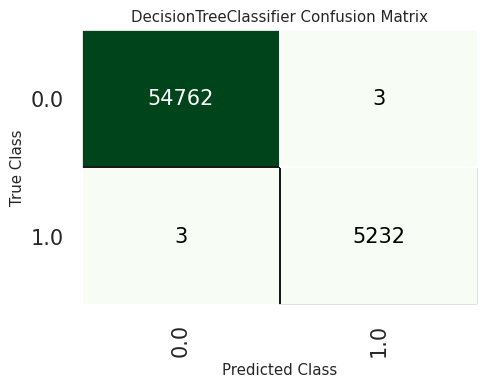

In [33]:
plt.figure(figsize = (5,4))
sns.set(font_scale=0.9)
exp.plot_model(best, plot = 'confusion_matrix')

The feature importance plot helps for undestanding which features hold the most valuable information about a possible fraudulent payment. In our case, it is the ratio between median and purchase price.

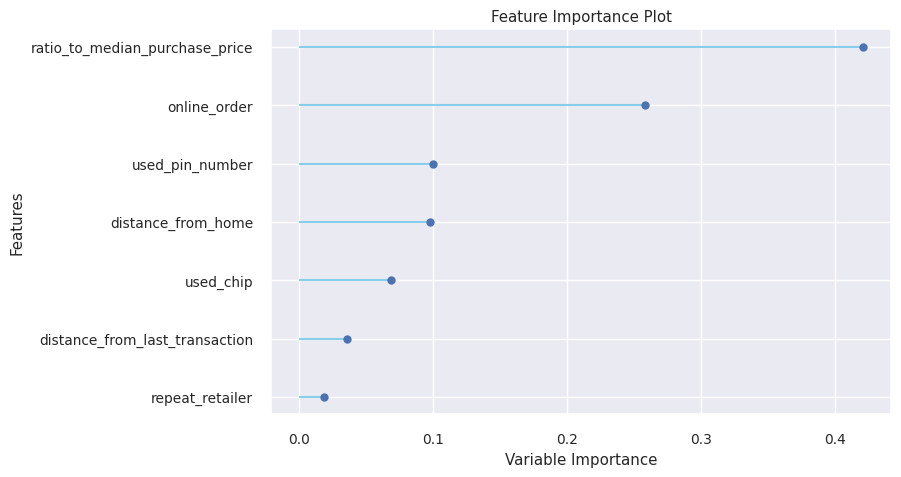

In [34]:
# plot feature importance
exp.plot_model(best, plot = 'feature')

### 5. Use model to predict if a transation is a fraud, or not

By calling `predict_model()` and passing the best algorithm to it, we get the predictions made by the best performing model over the test data. Predictions are stored in a column titled 'prediction_label'.

In [35]:
holdout_pred = exp.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9999,0.9997,0.9994,0.9994,0.9994,0.9994,0.9994


In [36]:
holdout_pred.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,prediction_label,prediction_score
65863,30.363974,0.304292,3.243304,1.0,0.0,0.0,1.0,0.0,0,1.0
172387,2.394236,0.568803,5.575444,1.0,0.0,0.0,1.0,1.0,1,1.0
68696,11.771614,0.455197,1.857862,1.0,1.0,0.0,1.0,0.0,0,1.0
131143,17.334951,1.672812,0.254477,1.0,1.0,1.0,1.0,0.0,0,1.0
86315,14.505174,3.277575,1.570382,1.0,0.0,0.0,1.0,0.0,0,1.0


In [37]:
print(f'Real number of positive (fraudulent) transations in test data: {holdout_pred.fraud.sum()}')
print(f'Predicted number of positive (fraudulent) transations in test data: {holdout_pred.prediction_label.sum()}')

Real number of positive (fraudulent) transations in test data: 5235.0
Predicted number of positive (fraudulent) transations in test data: 5235


The confusion matrix showed the misclassified transactions. These are displayed in the table below.

In [38]:
holdout_pred[(holdout_pred['fraud'] == 1) == (holdout_pred['prediction_label'] == 0.0)]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,prediction_label,prediction_score
21283,36.372726,49.884529,9.294384,1.0,0.0,0.0,0.0,0.0,1,1.0
50233,8.917953,50.001797,1.832696,1.0,0.0,0.0,1.0,1.0,0,1.0
156978,5.900974,52.847286,4.087215,1.0,0.0,1.0,1.0,1.0,0,1.0
195362,100.018608,0.244553,1.466988,1.0,0.0,0.0,1.0,1.0,0,1.0
102584,14.482244,64.064774,4.574435,1.0,1.0,1.0,1.0,0.0,1,1.0
59572,2.066725,153.612686,11.963059,1.0,1.0,1.0,1.0,0.0,1,1.0


The above described steps and functionalities proves that `PyCaret` is a very rich and convenient Machine Learning package. It should be noted here that its functions, experiments, and visuals could be tuned to meet the requirements of each particular task.